In [15]:
!pip install imblearn

Looking in indexes: https://mirrors.tools.huawei.com/pypi/simple


In [14]:
!pip install xgboost

Looking in indexes: https://mirrors.tools.huawei.com/pypi/simple
     ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
     ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
     -------------------------------------- 0.5/150.0 MB 837.5 kB/s eta 0:02:59
     -------------------------------------- 0.5/150.0 MB 837.5 kB/s eta 0:02:59
     -------------------------------------- 0.8/150.0 MB 931.2 kB/s eta 0:02:41
     -------------------------------------- 1.0/150.0 MB 948.7 kB/s eta 0:02:37
     ---------------------------------------- 1.3/150.0 MB 1.0 MB/s eta 0:02:25
     ---------------------------------------- 1.6/150.0 MB 1.1 MB/s eta 0:02:17
      --------------------------------------- 2.1/150.0 MB 1.2 MB/s eta 0:02:05
      --------------------------------------- 2.4/150.0 MB 1.3 MB/s eta 0:01:58
      --------------------------------------- 2.9/150.0 MB 1.3 MB/s eta 0:01

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [118]:
# 读取数据
# data = pd.read_excel('D:\\Files\\Data\\最新\\事件单分析\\场景\\11-12全部.xlsx')
data = pd.read_excel('D:\\Files\\Data\\最新\\事件单分析\\场景\\2024年11-12月标题描述.xlsx')

data = data.dropna(subset=['事件单号', '事件标题', '事件描述', '一层事件类别'])  # 清理缺失数据


In [119]:
# 定义标签
target_categories = ['服务器硬件问题', '产品问题', '网络设备硬件问题', '未定位根因']
data['分类类别'] = data['一层事件类别'].apply(lambda x: '硬件故障' if x in target_categories else '非硬件故障')
data['综合描述'] = data['事件标题'] + " " + data['事件描述']

In [120]:
# 数据集切分
X = data['综合描述']  
y = data['分类类别'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
# 文本特征提取（TF-IDF）
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [124]:
from gensim.models import Word2Vec
import numpy as np

# 准备数据：将文本分词
sentences = [text.split() for text in X_train]  # 将每条文本转换为词列表

# 训练 CBOW 模型
cbow_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, sg=1)

# 使用 CBOW 模型生成文本表示
def vectorize_text_cbow(text, model):
    words = text.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_train_cbow = np.array([vectorize_text_cbow(text, cbow_model) for text in X_train])
X_test_cbow = np.array([vectorize_text_cbow(text, cbow_model) for text in X_test])


In [99]:
!pip install jieba

Looking in indexes: https://mirrors.tools.huawei.com/pypi/simple
  Using cached jieba-0.42.1-py3-none-any.whl


In [10]:
import jieba
def preprocess_text(text):
    # 分词
    words = jieba.lcut(text)
    # 去除停用词
    stop_words = set(open('baidu_stopwords.txt', 'r', encoding='utf-8').read().split())
    words = [word for word in words if word not in stop_words]
    # 去除标点符号和数字
    words = [word for word in words if word.isalpha()]
    return ' '.join(words)

# 应用预处理
data['综合描述'] = data['综合描述'].apply(preprocess_text)

# 数据集切分
X = data['综合描述']  
y = data['分类类别'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 文本特征提取（TF-IDF）
vectorizer = TfidfVectorizer(max_features=None, ngram_range=(1, 3), min_df=2, max_df=0.8)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 处理类别不平衡
smote = SMOTE(random_state=42)
X_train_tfidf, y_train = smote.fit_resample(X_train_tfidf, y_train)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\L50046~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.682 seconds.
Prefix dict has been built successfully.


In [38]:
# 读取数据
# data = pd.read_excel('D:\\Files\\Data\\最新\\事件单分析\\场景\\11-12全部.xlsx')
data = pd.read_excel('D:\\Files\\Data\\最新\\事件单分析\\场景\\2024年11-12月标题描述.xlsx')

data = data.dropna(subset=['事件单号', '事件标题', '事件描述', '一层事件类别'])  # 清理缺失数据

# 定义标签
target_categories = ['服务器硬件问题', '产品问题', '网络设备硬件问题', '未定位根因']
data['分类类别'] = data['一层事件类别'].apply(lambda x: '硬件故障' if x in target_categories else '非硬件故障')
data['综合描述'] = data['事件标题'] + " " + data['事件描述']

# 数据集切分
X = data['综合描述']  
y = data['分类类别'] 

# 更彻底的文本清洗
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import jieba
stop_words = set(open('baidu_stopwords.txt', 'r', encoding='utf-8').read().split())
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    # 分词
    words = jieba.lcut(text)
    # 去除停用词
    words = [word for word in words if word not in stop_words]
    # 去除标点符号和数字
    words = [word for word in words if word.isalpha()]
    return ' '.join(words)
    
data['清洗后描述'] = data['综合描述'].apply(clean_text)

# 尝试不同的特征提取方法
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# 方案1：TF-IDF+词性特征
vectorizer1 = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 3),
    stop_words=stop_words
)
# 方案2：词向量平均
from gensim.models import Word2Vec
# 先训练Word2Vec模型
sentences = [text.split() for text in data['清洗后描述']]
w2v_model = Word2Vec(sentences, vector_size=300, window=5, min_count=3, workers=4)
def document_vector(text):
    words = text.split()
    word_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(word_vecs) == 0:
        return np.zeros(300)
    return np.mean(word_vecs, axis=0)
X_w2v = np.array([document_vector(text) for text in data['清洗后描述']])


In [40]:
# 组合TF-IDF和词向量特征
from scipy.sparse import hstack
X_tfidf = vectorizer.fit_transform(data['清洗后描述'])
X_combined = hstack([X_tfidf, X_w2v])

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [6]:
# 训练分类模型
# model = LogisticRegression(random_state=42)
model = RandomForestClassifier(class_weight='balanced', random_state=42)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)
model.fit(X_train_balanced, y_train_balanced)
# model.fit(X_train_tfidf, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [6]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# 初始化决策树模型
dt_model = DecisionTreeClassifier(random_state=42)

# 网格搜索
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_tfidf, y_train)

# Step 6: 结果输出
print("最佳参数：", grid_search.best_params_)
print("最佳准确率：", grid_search.best_score_)

# 预测测试集结果
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("测试集准确率：", accuracy)

# 保存结果到Excel
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.to_excel('decision_tree_tuning_results.xlsx', index=False)
print("所有参数组合结果已保存到 'decision_tree_tuning_results.xlsx'")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
最佳参数： {'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
最佳准确率： 0.776569815219578
测试集准确率： 0.7510548523206751
所有参数组合结果已保存到 'decision_tree_tuning_results.xlsx'


In [7]:
overall_accuracy = accuracy_score(y_test, y_pred)
hardware_accuracy = accuracy_score(y_test[y_test == '硬件故障'], y_pred[y_test == '硬件故障'])
non_hardware_accuracy = accuracy_score(y_test[y_test == '非硬件故障'], y_pred[y_test == '非硬件故障'])
print(f"整体准确率={overall_accuracy:.4f}, 硬件故障分类准确率={hardware_accuracy:.4f}, 非硬件故障分类准确率={non_hardware_accuracy:.4f}")

整体准确率=0.7511, 硬件故障分类准确率=0.7241, 非硬件故障分类准确率=0.8043


In [127]:
# Logistic Regression
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
}

results = []
for penalty in param_grid['penalty']:
    for C in param_grid['C']:
        for solver in param_grid['solver']:
            # 条件判断，确保参数组合合法
            if penalty == 'l1' and solver not in ['liblinear', 'saga']:
                continue
            if penalty == 'l2' and solver not in ['liblinear', 'saga', 'lbfgs', 'newton-cg']:
                continue
            model = LogisticRegression(penalty=penalty, C=C, solver=solver, random_state=42)
            try:
                model.fit(X_train_tfidf, y_train) # X_train_tfidf X_train_cbow
                y_pred = model.predict(X_test_tfidf) # X_test_tfidf X_test_cbow
                overall_accuracy = accuracy_score(y_test, y_pred)
                hardware_accuracy = accuracy_score(y_test[y_test == '硬件故障'], y_pred[y_test == '硬件故障'])
                non_hardware_accuracy = accuracy_score(y_test[y_test == '非硬件故障'], y_pred[y_test == '非硬件故障'])
                    
                # 记录结果
                results.append({
                    'penalty': penalty,
                    'C': C,
                    'solver': solver,
                    '整体准确率': overall_accuracy,
                    '硬件故障分类准确率': hardware_accuracy,
                    '非硬件故障分类准确率': non_hardware_accuracy
                })
                
                print(f"参数组合: penalty={penalty}, C={C}, solver={solver}, 整体准确率={overall_accuracy:.4f}, 硬件故障分类准确率={hardware_accuracy:.4f}, 非硬件故障分类准确率={non_hardware_accuracy:.4f}")
            
            except Exception as e:
                print(f"参数组合失败: penalty={penalty}, C={C}, solver={solver}, 错误={str(e)}")

# Step 7: 保存结果到Excel
results_df = pd.DataFrame(results)
results_df.to_excel('cbow_logistic_regression_tuning_results.xlsx', index=False)
sorted_results = results_df.sort_values(by='整体准确率', ascending=False)

print("前5个最佳参数组合:")
print(sorted_results.head())

参数组合: penalty=l1, C=0.01, solver=liblinear, 整体准确率=0.6643, 硬件故障分类准确率=1.0000, 非硬件故障分类准确率=0.0000
参数组合: penalty=l1, C=0.01, solver=saga, 整体准确率=0.6643, 硬件故障分类准确率=1.0000, 非硬件故障分类准确率=0.0000
参数组合: penalty=l1, C=0.1, solver=liblinear, 整体准确率=0.6896, 硬件故障分类准确率=0.9401, 非硬件故障分类准确率=0.1939
参数组合: penalty=l1, C=0.1, solver=saga, 整体准确率=0.6896, 硬件故障分类准确率=0.9392, 非硬件故障分类准确率=0.1957
参数组合: penalty=l1, C=1, solver=liblinear, 整体准确率=0.7782, 硬件故障分类准确率=0.8394, 非硬件故障分类准确率=0.6571


C:\Users\l50046825\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


参数组合: penalty=l1, C=1, solver=saga, 整体准确率=0.7770, 硬件故障分类准确率=0.8394, 非硬件故障分类准确率=0.6535
参数组合: penalty=l1, C=10, solver=liblinear, 整体准确率=0.7740, 硬件故障分类准确率=0.8131, 非硬件故障分类准确率=0.6966


C:\Users\l50046825\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


参数组合: penalty=l1, C=10, solver=saga, 整体准确率=0.7848, 硬件故障分类准确率=0.8240, 非硬件故障分类准确率=0.7074
参数组合: penalty=l1, C=100, solver=liblinear, 整体准确率=0.7511, 硬件故障分类准确率=0.7985, 非硬件故障分类准确率=0.6571


C:\Users\l50046825\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


参数组合: penalty=l1, C=100, solver=saga, 整体准确率=0.7601, 硬件故障分类准确率=0.8031, 非硬件故障分类准确率=0.6750
参数组合: penalty=l2, C=0.01, solver=liblinear, 整体准确率=0.6618, 硬件故障分类准确率=0.9837, 非硬件故障分类准确率=0.0251
参数组合: penalty=l2, C=0.01, solver=saga, 整体准确率=0.6643, 硬件故障分类准确率=0.9873, 非硬件故障分类准确率=0.0251
参数组合: penalty=l2, C=0.01, solver=lbfgs, 整体准确率=0.6637, 硬件故障分类准确率=0.9873, 非硬件故障分类准确率=0.0233
参数组合: penalty=l2, C=0.01, solver=newton-cg, 整体准确率=0.6643, 硬件故障分类准确率=0.9873, 非硬件故障分类准确率=0.0251
参数组合: penalty=l2, C=0.1, solver=liblinear, 整体准确率=0.7462, 硬件故障分类准确率=0.8984, 非硬件故障分类准确率=0.4452
参数组合: penalty=l2, C=0.1, solver=saga, 整体准确率=0.7468, 硬件故障分类准确率=0.9011, 非硬件故障分类准确率=0.4417
参数组合: penalty=l2, C=0.1, solver=lbfgs, 整体准确率=0.7474, 硬件故障分类准确率=0.9002, 非硬件故障分类准确率=0.4452
参数组合: penalty=l2, C=0.1, solver=newton-cg, 整体准确率=0.7474, 硬件故障分类准确率=0.9011, 非硬件故障分类准确率=0.4434
参数组合: penalty=l2, C=1, solver=liblinear, 整体准确率=0.7878, 硬件故障分类准确率=0.8439, 非硬件故障分类准确率=0.6768
参数组合: penalty=l2, C=1, solver=saga, 整体准确率=0.7878, 硬件故障分类准确率=0.8439, 非硬件故障分类准确率=0.6768
参数组合:

C:\Users\l50046825\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


参数组合: penalty=l2, C=100, solver=saga, 整体准确率=0.7691, 硬件故障分类准确率=0.8103, 非硬件故障分类准确率=0.6876


C:\Users\l50046825\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


参数组合: penalty=l2, C=100, solver=lbfgs, 整体准确率=0.7637, 硬件故障分类准确率=0.8058, 非硬件故障分类准确率=0.6804
参数组合: penalty=l2, C=100, solver=newton-cg, 整体准确率=0.7631, 硬件故障分类准确率=0.8058, 非硬件故障分类准确率=0.6786
前5个最佳参数组合:
   penalty     C     solver     整体准确率  硬件故障分类准确率  非硬件故障分类准确率
25      l2  10.0  newton-cg  0.795660   0.832123    0.723519
24      l2  10.0      lbfgs  0.795057   0.833031    0.719928
22      l2  10.0  liblinear  0.794454   0.831216    0.721724
23      l2  10.0       saga  0.794454   0.831216    0.721724
19      l2   1.0       saga  0.787824   0.843920    0.676840


In [43]:
test_results = pd.DataFrame({
    '事件单号': data.loc[X_test.index, '事件单号'],
    '事件标题': data.loc[X_test.index, '事件标题'],
    '事件描述': data.loc[X_test.index, '事件描述'],
    '一层事件类别': data.loc[X_test.index, '一层事件类别'],
    '分类类别': y_pred  # 预测的分类类别
})
test_results.to_excel('logistic_regression_results.xlsx', index=False)

In [97]:
import numpy as np

# 选取最佳准确率的模型
best_params = sorted_results.iloc[0]  # 选择排名第一的参数组合
best_model = LogisticRegression(penalty=best_params['penalty'], C=best_params['C'], solver=best_params['solver'], random_state=42)

# 重新训练最佳模型
best_model.fit(X_train_tfidf, y_train)
y_pred_best = best_model.predict(X_test_tfidf)

# 获取每个样本的分类概率
y_probs = best_model.predict_proba(X_test_tfidf)

# 设定阈值
threshold = 0.75

# 找到每个样本最高的分类概率
max_probs = np.max(y_probs, axis=1)
pred_classes = best_model.classes_[np.argmax(y_probs, axis=1)]

# 根据置信度调整分类结果
adjusted_pred_classes = np.where(max_probs >= threshold, pred_classes, "未分类")

# 创建数据框
test_results_adjusted = pd.DataFrame({
    '事件单号': data.loc[X_test.index, '事件单号'],
    '事件标题': data.loc[X_test.index, '事件标题'],
    '事件描述': data.loc[X_test.index, '事件描述'],
    '一层事件类别': data.loc[X_test.index, '一层事件类别'],
    '真实类别': y_test,
    '原始分类类别': y_pred_best,
    '置信度': max_probs,
    '调整后分类类别': adjusted_pred_classes
})

# 保存到Excel
test_results_adjusted.to_excel('adjusted_classification_results.xlsx', index=False)

print("已调整分类结果，低置信度的样本被标记为‘未分类’。")


已调整分类结果，低置信度的样本被标记为‘未分类’。


In [98]:
from sklearn.metrics import recall_score

# 计算召回率（只考虑被分类的样本）
valid_indices = adjusted_pred_classes != "未分类"
recall = recall_score(y_test[valid_indices], adjusted_pred_classes[valid_indices], average='macro')

# 计算置信度覆盖率（有多少样本被分类）
confidence_coverage = np.mean(valid_indices) * 100

# 计算误分类比例
misclassified_counts = test_results_adjusted[(test_results_adjusted['真实类别'] != test_results_adjusted['调整后分类类别'] ) & (test_results_adjusted['调整后分类类别'] != "未分类")]
misclassification_rate = (len(misclassified_counts) / len(test_results_adjusted)) * 100

correctclassified_counts = test_results_adjusted[(test_results_adjusted['真实类别'] == test_results_adjusted['调整后分类类别'] ) & (test_results_adjusted['调整后分类类别'] != "未分类")]
correctclassification_rate = (len(correctclassified_counts) / len(test_results_adjusted)) * 100

# 输出评估结果
print(f"召回率: {recall:.2f}")
print(f"置信度覆盖率: {confidence_coverage:.2f}%")
print(f"误分类比例: {misclassification_rate:.2f}%")
print(f"正确分类比例: {correctclassification_rate:.2f}%")

召回率: 0.83
置信度覆盖率: 77.76%
误分类比例: 11.69%
正确分类比例: 66.06%


In [117]:
import spacy
import pandas as pd

# 加载 spaCy 预训练模型（中型版本）
nlp = spacy.load("zh_core_web_md")  # 如果是中文数据，可以用 "zh_core_web_md"

# 示例：计算两个文本的语义相似度
def compute_similarity(text1, text2):
    doc1 = nlp(text1)
    doc2 = nlp(text2)
    return doc1.similarity(doc2)

# 计算所有测试样本之间的语义相似度
test_results_adjusted["语义相似度"] = test_results_adjusted.apply(
    lambda row: compute_similarity(row["事件描述"], row["事件标题"]), axis=1
)

# 找出误分类样本
incorrect_results = test_results_adjusted[test_results_adjusted["真实类别"] != test_results_adjusted["调整后分类类别"]]

# 找出误分类样本中语义相似度最高的类别
similarity_analysis = incorrect_results.groupby("真实类别")["语义相似度"].mean().reset_index()
similarity_analysis.sort_values(by="语义相似度", ascending=False, inplace=True)

print(similarity_analysis)


    真实类别     语义相似度
1  非硬件故障  0.668344
0   硬件故障  0.647856


In [116]:
!python -m spacy download zh_core_web_md


Looking in indexes: https://mirrors.tools.huawei.com/pypi/simple
  Using cached https://github.com/explosion/spacy-models/releases/download/zh_core_web_md-3.7.0/zh_core_web_md-3.7.0-py3-none-any.whl (78.0 MB)
     ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
     ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
     -------- ------------------------------- 0.5/2.4 MB 1.9 MB/s eta 0:00:02
     ----------------- ---------------------- 1.0/2.4 MB 2.2 MB/s eta 0:00:01
     ---------------------------------- ----- 2.1/2.4 MB 2.9 MB/s eta 0:00:01
     ---------------------------------------- 2.4/2.4 MB 3.0 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('zh_core_web_md')


In [89]:
incorrect_results = test_results[test_results['分类类别'] != test_results['一层事件类别']]
error_distribution = incorrect_results.groupby('一层事件类别').size().reset_index(name='误分类数量')
print(error_distribution)


        一层事件类别  误分类数量
0           --      1
1         产品问题      6
2   伙伴云伙伴侧根因问题      6
3        咨询请求单    414
4       基础设施机房      3
5        客户侧问题    112
6      服务器硬件问题   1068
7           演练      4
8     网络设备硬件问题     28
9         资源问题      1
10        配置问题     16


In [58]:
# 计算总样本数
total_counts = test_results.groupby('一层事件类别').size().reset_index(name='总样本数')

# 计算误分类次数
misclassified_counts = incorrect_results.groupby(['一层事件类别', '分类类别']).size().reset_index(name='误分类次数')

# 合并数据
misclassified_rates = misclassified_counts.merge(total_counts, on='一层事件类别', how='left')

# 计算误分类比例
misclassified_rates['误分类比例'] = misclassified_rates['误分类次数'] / misclassified_rates['总样本数']

print(misclassified_rates)


        一层事件类别   分类类别  误分类次数  总样本数     误分类比例
0           --  非硬件故障      1     1  1.000000
1         产品问题   硬件故障      3     6  0.500000
2         产品问题  非硬件故障      3     6  0.500000
3   伙伴云伙伴侧根因问题   硬件故障      3     6  0.500000
4   伙伴云伙伴侧根因问题  非硬件故障      3     6  0.500000
5        咨询请求单   硬件故障    122   414  0.294686
6        咨询请求单  非硬件故障    292   414  0.705314
7       基础设施机房   硬件故障      1     3  0.333333
8       基础设施机房  非硬件故障      2     3  0.666667
9        客户侧问题   硬件故障     49   112  0.437500
10       客户侧问题  非硬件故障     63   112  0.562500
11     服务器硬件问题   硬件故障    900  1068  0.842697
12     服务器硬件问题  非硬件故障    168  1068  0.157303
13          演练   硬件故障      3     4  0.750000
14          演练  非硬件故障      1     4  0.250000
15    网络设备硬件问题   硬件故障     18    28  0.642857
16    网络设备硬件问题  非硬件故障     10    28  0.357143
17        资源问题   硬件故障      1     1  1.000000
18        配置问题   硬件故障      8    16  0.500000
19        配置问题  非硬件故障      8    16  0.500000


In [51]:
# 计算总测试集样本数
total_test_samples = len(test_results)

# 计算误分类次数
misclassified_counts = incorrect_results.groupby(['一层事件类别', '分类类别']).size().reset_index(name='误分类次数')

# 计算误分类比例（相对于整个测试集）并转换为百分比格式
misclassified_counts['误分类占比 (%)'] = (misclassified_counts['误分类次数'] / total_test_samples) * 100

# 格式化为两位小数
misclassified_counts['误分类占比 (%)'] = misclassified_counts['误分类占比 (%)'].round(2)

print(misclassified_counts)


        一层事件类别   分类类别  误分类次数  误分类占比 (%)
0           --  非硬件故障      1       0.06
1         产品问题   硬件故障      3       0.18
2         产品问题  非硬件故障      3       0.18
3   伙伴云伙伴侧根因问题   硬件故障      3       0.18
4   伙伴云伙伴侧根因问题  非硬件故障      3       0.18
5        咨询请求单   硬件故障    122       7.35
6        咨询请求单  非硬件故障    292      17.60
7       基础设施机房   硬件故障      1       0.06
8       基础设施机房  非硬件故障      2       0.12
9        客户侧问题   硬件故障     49       2.95
10       客户侧问题  非硬件故障     63       3.80
11     服务器硬件问题   硬件故障    900      54.25
12     服务器硬件问题  非硬件故障    168      10.13
13          演练   硬件故障      3       0.18
14          演练  非硬件故障      1       0.06
15    网络设备硬件问题   硬件故障     18       1.08
16    网络设备硬件问题  非硬件故障     10       0.60
17        资源问题   硬件故障      1       0.06
18        配置问题   硬件故障      8       0.48
19        配置问题  非硬件故障      8       0.48


In [78]:
# 确保 target_categories 定义正确
target_categories = ['服务器硬件问题', '产品问题', '网络设备硬件问题', '未定位根因']

# 计算正确的预期分类
test_results['预期分类类别'] = test_results['一层事件类别'].apply(lambda x: '硬件故障' if x in target_categories else '非硬件故障')

# 找出分类错误的样本
misclassified_cases = test_results[test_results['分类类别'] != test_results['预期分类类别']]
classified_cases = test_results[test_results['分类类别'] == test_results['预期分类类别']]

print(misclassified_cases['一层事件类别'].value_counts())  # 查看误分类类别


一层事件类别
服务器硬件问题       168
咨询请求单         122
客户侧问题          49
网络设备硬件问题       10
配置问题            8
伙伴云伙伴侧根因问题      3
产品问题            3
演练              3
基础设施机房          1
资源问题            1
Name: count, dtype: int64


In [79]:
misclassified_cases.loc[:, '描述长度'] = misclassified_cases['事件描述'].apply(len)
classified_cases.loc[:, '描述长度'] = classified_cases['事件描述'].apply(len)
print("分类正确样本的平均描述长度：", classified_cases['描述长度'].mean())
print("分类正确样本的描述长度分布：")
print(classified_cases['描述长度'].describe())
print("分类错误样本的平均描述长度：", misclassified_cases['描述长度'].mean())
print("分类错误样本的描述长度分布：")
print(misclassified_cases['描述长度'].describe())

分类正确样本的平均描述长度： 711.8048024786987
分类正确样本的描述长度分布：
count    1291.000000
mean      711.804802
std       557.055064
min        21.000000
25%       301.500000
50%       599.000000
75%      1000.500000
max      4096.000000
Name: 描述长度, dtype: float64
分类错误样本的平均描述长度： 481.0679347826087
分类错误样本的描述长度分布：
count     368.000000
mean      481.067935
std       407.217284
min        20.000000
25%       213.000000
50%       350.500000
75%       602.000000
max      4096.000000
Name: 描述长度, dtype: float64


C:\Users\l50046825\AppData\Local\Temp\ipykernel_61712\2951256444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_cases.loc[:, '描述长度'] = misclassified_cases['事件描述'].apply(len)
C:\Users\l50046825\AppData\Local\Temp\ipykernel_61712\2951256444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classified_cases.loc[:, '描述长度'] = classified_cases['事件描述'].apply(len)


正确分类的类别分布：
一层事件类别
服务器硬件问题       900
咨询请求单         292
客户侧问题          63
网络设备硬件问题       18
配置问题            8
伙伴云伙伴侧根因问题      3
产品问题            3
基础设施机房          2
--              1
演练              1
Name: count, dtype: int64
错误分类的类别分布：
一层事件类别
服务器硬件问题       168
咨询请求单         122
客户侧问题          49
网络设备硬件问题       10
配置问题            8
伙伴云伙伴侧根因问题      3
产品问题            3
演练              3
基础设施机房          1
资源问题            1
Name: count, dtype: int64


C:\Users\l50046825\AppData\Local\Temp\ipykernel_61712\1338387587.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classified_cases['描述长度'] = classified_cases['事件描述'].apply(len)
C:\Users\l50046825\AppData\Local\Temp\ipykernel_61712\1338387587.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_cases['描述长度'] = misclassified_cases['事件描述'].apply(len)


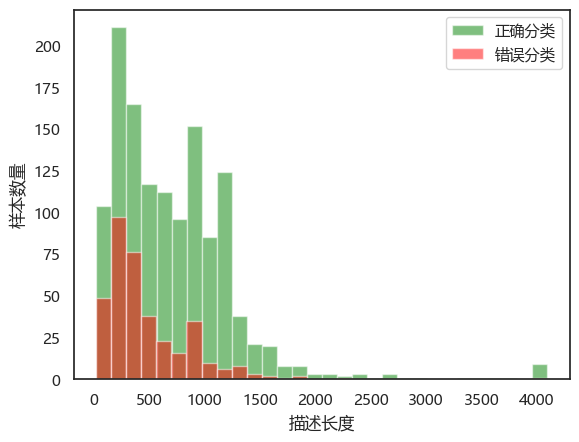

In [87]:
import matplotlib.pyplot as plt 
import os
print("正确分类的类别分布：") 
print(classified_cases['一层事件类别'].value_counts()) 
print("错误分类的类别分布：") 
print(misclassified_cases['一层事件类别'].value_counts()) 
classified_cases['描述长度'] = classified_cases['事件描述'].apply(len) 
misclassified_cases['描述长度'] = misclassified_cases['事件描述'].apply(len) 
plt.hist(classified_cases['描述长度'], bins=30, alpha=0.5, label='正确分类', color='green') 
plt.hist(misclassified_cases['描述长度'], bins=30, alpha=0.5, label='错误分类', color='red') 
plt.xlabel('描述长度') 
plt.ylabel('样本数量') 
plt.legend() 
output_dir = "D:\\Files\\时序预测"
os.makedirs(output_dir, exist_ok=True)
image_path = os.path.join(output_dir, "描述长度分布.png")
plt.savefig(image_path, dpi=300, bbox_inches='tight')
plt.show()

C:\Users\l50046825\AppData\Local\Temp\ipykernel_61712\3418753436.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classified_cases['描述长度'] = classified_cases['事件描述'].apply(len)
C:\Users\l50046825\AppData\Local\Temp\ipykernel_61712\3418753436.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_cases['描述长度'] = misclassified_cases['事件描述'].apply(len)


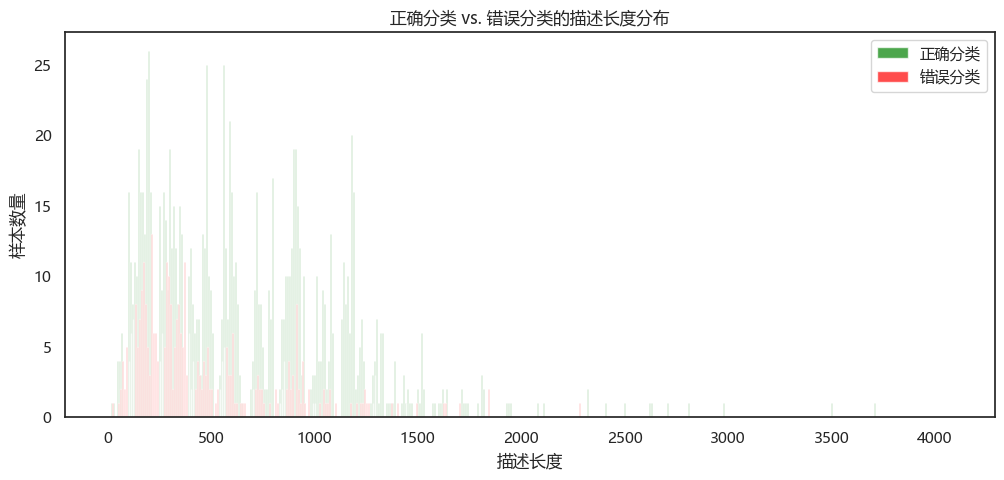

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import os

# 计算描述长度
classified_cases['描述长度'] = classified_cases['事件描述'].apply(len)
misclassified_cases['描述长度'] = misclassified_cases['事件描述'].apply(len)

# 设置更大的分组间隔，例如每 10 个单位作为一个类别
bins = np.arange(0, max(classified_cases['描述长度'].max(), misclassified_cases['描述长度'].max()) + 1, 10)

# 统计描述长度分布
correct_counts, _ = np.histogram(classified_cases['描述长度'], bins=bins)
wrong_counts, _ = np.histogram(misclassified_cases['描述长度'], bins=bins)

# 设置柱形图宽度
bar_width = 4
x_positions = bins[:-1]

plt.figure(figsize=(12, 5))

# 画出正确分类的柱状图
plt.bar(x_positions, correct_counts, width=bar_width, label='正确分类', color='green', alpha=0.7)

# 画出错误分类的柱状图（稍微偏移，让它们并排而不是堆叠）
plt.bar(x_positions + bar_width, wrong_counts, width=bar_width, label='错误分类', color='red', alpha=0.7)

plt.xlabel('描述长度')
plt.ylabel('样本数量')
plt.title('正确分类 vs. 错误分类的描述长度分布')
plt.legend()
output_dir = "D:\\Files\\时序预测"
os.makedirs(output_dir, exist_ok=True)
image_path = os.path.join(output_dir, "描述长度分布.png")
plt.savefig(image_path, dpi=300, bbox_inches='tight')
plt.show()


In [52]:
from sklearn.feature_extraction.text import CountVectorizer

correct_texts = incorrect_results['事件描述']
vectorizer = CountVectorizer(max_features=20, ngram_range=(1, 2))
word_counts = vectorizer.fit_transform(correct_texts)
feature_names = vectorizer.get_feature_names_out()

print("误分类文本中的高频关键词:", feature_names)


误分类文本中的高频关键词: ['01' '10' '11' '26' 'br' 'cloudautoremediation' 'com' 'details' 'https'
 'huaweisre' 'huaweisre com' 'null' 'null 服务经理' 'server' '客户名字' '客户级别'
 '服务经理' '状态' '虚拟机id' '规格']


In [48]:
test_results['真实类别'] = y_test
test_results['预测正确'] = test_results['分类类别'] == test_results['真实类别']
misclassified = test_results[~test_results['预测正确']]
# 按类别分组查看
misclassified_grouped = misclassified.groupby(['真实类别', '分类类别']).size().unstack()


# 分析硬件故障被误判为非硬件故障的案例
false_negatives = misclassified[misclassified['真实类别'] == '硬件故障']
# 分析非硬件故障被误判为硬件故障的案例
false_positives = misclassified[misclassified['真实类别'] == '非硬件故障']
# 可以进一步分析这些案例中的关键词模式
from collections import Counter
def analyze_keywords(cases, vectorizer, n=20):
    # 提取这些案例的文本
    texts = cases['事件标题'] + " " + cases['事件描述']
    # 使用相同的vectorizer转换
    X = vectorizer.transform(texts)
    # 获取非零特征
    sums = X.sum(axis=0)
    features = vectorizer.get_feature_names_out()
    word_counts = [(word, sums[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    word_counts = sorted(word_counts, key=lambda x: -x[1])
    return word_counts[:n]
print("硬件故障误判案例中的高频词:")
print(analyze_keywords(false_negatives, vectorizer))
print("\n非硬件故障误判案例中的高频词:")
print(analyze_keywords(false_positives, vectorizer))

硬件故障误判案例中的高频词:
[('10', 118), ('11', 111), ('cloudautoremediation', 91), ('26', 72), ('null', 69), ('01', 51), ('https', 35), ('com', 33), ('虚拟机id', 32), ('huaweisre', 31), ('details', 31), ('huaweisre com', 31), ('服务经理', 31), ('server', 29), ('规格', 27), ('客户名字', 25), ('客户级别', 24), ('状态', 24), ('null 服务经理', 24), ('br', 22)]

非硬件故障误判案例中的高频词:
[('cloudautoremediation', 247), ('10', 201), ('null', 177), ('11', 115), ('虚拟机id', 100), ('com', 99), ('客户级别', 98), ('https', 97), ('规格', 92), ('客户名字', 91), ('服务经理', 87), ('huaweisre', 86), ('huaweisre com', 86), ('details', 85), ('状态', 83), ('br', 83), ('null 服务经理', 83), ('26', 83), ('server', 77), ('01', 77)]


In [64]:

import requests

stopwords_url = "https://raw.githubusercontent.com/goto456/stopwords/master/cn_stopwords.txt"
response = requests.get(stopwords_url)
chinese_stop_words = set(response.text.split('\n'))

stop_words_list = list(chinese_stop_words)

vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    stop_words=stop_words_list
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

server_hardware_misclassified = test_results[
    (test_results['一层事件类别'] == '服务器硬件问题') & 
    (~test_results['预测正确'])
]

texts = server_hardware_misclassified['事件标题'] + ' ' + server_hardware_misclassified['事件描述']

def analyze_ngrams(texts, n=2, top_n=20):
    vectorizer = CountVectorizer(
        ngram_range=(n, n),
        stop_words=stop_words_list,
        max_features=5000
    )
    X = vectorizer.fit_transform(texts)
    features = vectorizer.get_feature_names_out()
    sums = X.sum(axis=0)
    data = [(word, sums[0, idx]) for idx, word in enumerate(features)]
    return pd.DataFrame(data, columns=['word', 'count']).sort_values('count', ascending=False).head(top_n)

print("服务器硬件问题误判案例中的高频词:")
print(analyze_ngrams(texts, n=1))
print("\n服务器硬件问题误判案例中的高频双词短语:")
print(analyze_ngrams(texts, n=2))
print("\n服务器硬件问题误判案例中的高频三词短语:")
print(analyze_ngrams(texts, n=3))

C:\Users\l50046825\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['若果'] not in stop_words.
  warnings.warn(


服务器硬件问题误判案例中的高频词:
                      word  count
2574                  故障现象    143
1039               _x000d_    138
128                     10    107
2978                  资源信息     97
2487                  已做排查     97
2573                  故障影响     97
144                     11     92
1372  cloudautoremediation     91
2526                  当前问题     80
1907                  null     69
2753                  租户id     64
2458                客户是否授权     63
2456              客户所属资源id     62
2572                  故障局点     62
2383                  发生时间     62
2199           一线已做的基础排查工作     61
2569                故障复现场景     61
397                     26     61
162                     12     58
1874                    na     54

服务器硬件问题误判案例中的高频双词短语:
                                           word  count
3815                              客户所属资源id 租户id     62
4468                                  租户id 故障局点     62
4199                                  故障现象 发生时间     61
4170                      

C:\Users\l50046825\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['若果'] not in stop_words.
  warnings.warn(
C:\Users\l50046825\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['若果'] not in stop_words.
  warnings.warn(


In [66]:
# 获取正确分类的服务器硬件问题案例
correctly_classified = test_results[
    (test_results['一层事件类别'] == '服务器硬件问题') & 
    (test_results['预测正确'])
]
# 比较两组的关键词差异
def compare_keywords(group1, group2, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, 
                                stop_words=stop_words_list,
                                max_features=5000)
    
    # 合并两组文本
    all_texts = list(group1['事件标题'] + ' ' + group1['事件描述']) + \
                list(group2['事件标题'] + ' ' + group2['事件描述'])
    
    # 创建标签
    labels = ['误判'] * len(group1) + ['正确'] * len(group2)
    
    # 向量化
    X = vectorizer.fit_transform(all_texts)
    
    # 计算每个词在两组中的平均TF-IDF分数
    df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    df['label'] = labels
    
    # 分组计算均值
    grouped = df.groupby('label').mean()
    
    # 计算差异
    diff = grouped.loc['误判'] - grouped.loc['正确']
    return diff.sort_values(ascending=False)
keyword_diff = compare_keywords(server_hardware_misclassified, correctly_classified)
print("误判案例中更显著的关键词:")
print(keyword_diff.head(20))

C:\Users\l50046825\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['若果'] not in stop_words.
  warnings.warn(


误判案例中更显著的关键词:
_x000d_               0.062939
故障现象                  0.051924
故障影响                  0.041492
已做排查                  0.041492
资源信息                  0.041352
当前问题                  0.037220
na                    0.029298
客户是否授权                0.028559
一线已做的基础排查工作           0.027955
租户id                  0.027892
故障现象 发生时间             0.027837
故障复现场景                0.027837
发生时间                  0.027630
租户id 故障局点             0.027285
客户所属资源id              0.027285
客户所属资源id 租户id         0.027285
故障局点                  0.027285
一线已做的基础排查工作 客户是否授权    0.024851
故障复现场景 一线已做的基础排查工作    0.022225
发生时间 故障复现场景           0.019366
dtype: float64


In [28]:
import seaborn as sns
sns.set_theme(style="white", rc={"axes.facecolor": "none", "grid.color": "none"})

In [33]:
!pip install seaborn

Looking in indexes: https://mirrors.tools.huawei.com/pypi/simple


前5个最佳参数组合:
   penalty     C     solver     整体准确率  硬件故障分类准确率  非硬件故障分类准确率
18      l2   1.0  liblinear  0.793852   0.849365    0.684022
19      l2   1.0       saga  0.793852   0.849365    0.684022
20      l2   1.0      lbfgs  0.793249   0.847550    0.685817
21      l2   1.0  newton-cg  0.793249   0.849365    0.682226
24      l2  10.0      lbfgs  0.788427   0.824864    0.716338


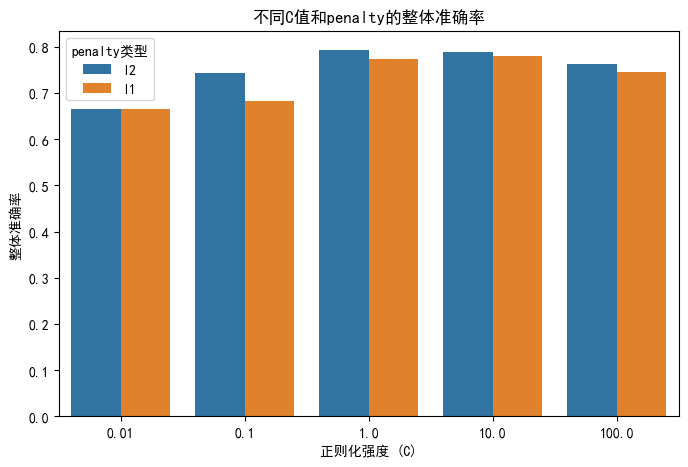

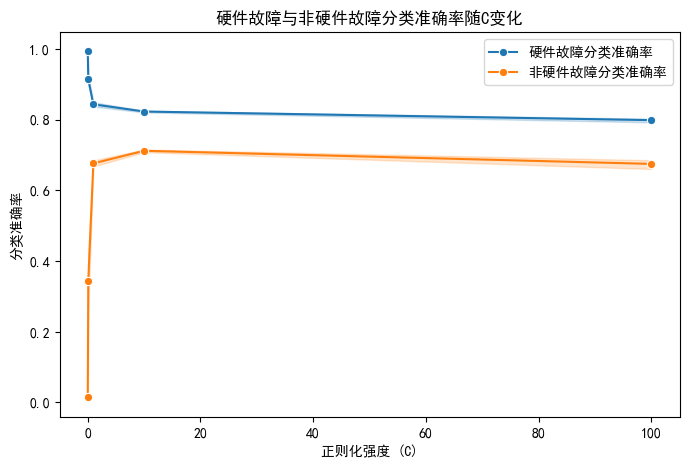

最佳参数表格已保存为 'top_10_best_parameters.xlsx'


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# Step 1: 读取调参结果
results_df = pd.read_excel('logistic_regression_tuning_results.xlsx')

# Step 2: 表格分析
# 对数据进行排序（按整体准确率降序排列）
sorted_results = results_df.sort_values(by='整体准确率', ascending=False)

# 打印前5个最佳参数组合
print("前5个最佳参数组合:")
print(sorted_results.head())

# Step 3: 绘制柱状图分析分类准确率
plt.figure(figsize=(8, 5))
sns.barplot(data=sorted_results, x='C', y='整体准确率', hue='penalty', errorbar=None)
plt.title('不同C值和penalty的整体准确率')
plt.xlabel('正则化强度 (C)')
plt.ylabel('整体准确率')
plt.legend(title='penalty类型')
plt.savefig('accuracy_analysis_by_c_penalty.png')  # 保存图片
plt.show()

# Step 4: 绘制硬件故障与非硬件故障分类准确率的比较
plt.figure(figsize=(8, 5))
sns.lineplot(data=sorted_results, x='C', y='硬件故障分类准确率', label='硬件故障分类准确率', marker='o')
sns.lineplot(data=sorted_results, x='C', y='非硬件故障分类准确率', label='非硬件故障分类准确率', marker='o')
plt.title('硬件故障与非硬件故障分类准确率随C变化')
plt.xlabel('正则化强度 (C)')
plt.ylabel('分类准确率')
plt.legend()
plt.savefig('classification_accuracy_comparison.png')  # 保存图片
plt.show()

# Step 5: 保存整理后的最佳参数表格
sorted_results.head(10).to_excel('top_10_best_parameters.xlsx', index=False)
print("最佳参数表格已保存为 'top_10_best_parameters.xlsx'")


按solver分组的准确率平均值:
      solver     整体准确率  硬件故障分类准确率  非硬件故障分类准确率
0      lbfgs  0.751055   0.873684    0.508438
1  liblinear  0.738336   0.873412    0.471095
2  newton-cg  0.749729   0.873684    0.504488
3       saga  0.740989   0.875408    0.475045


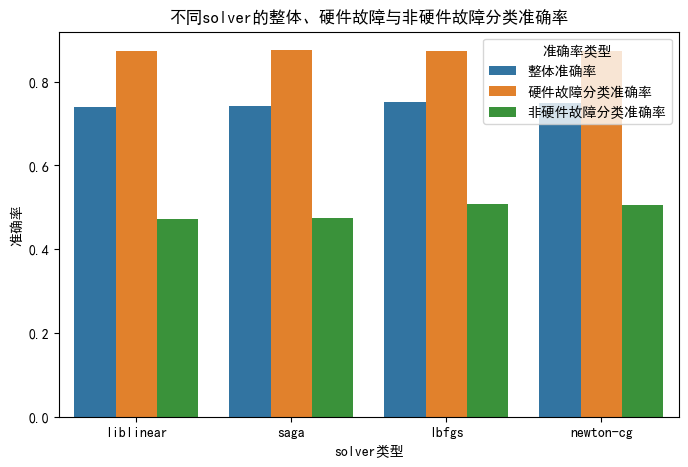

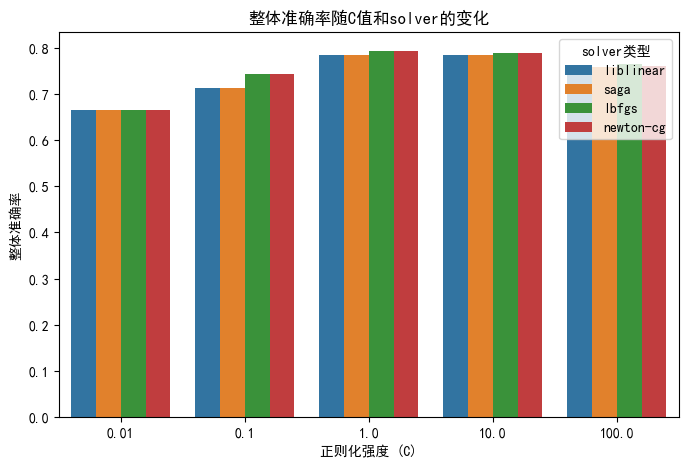

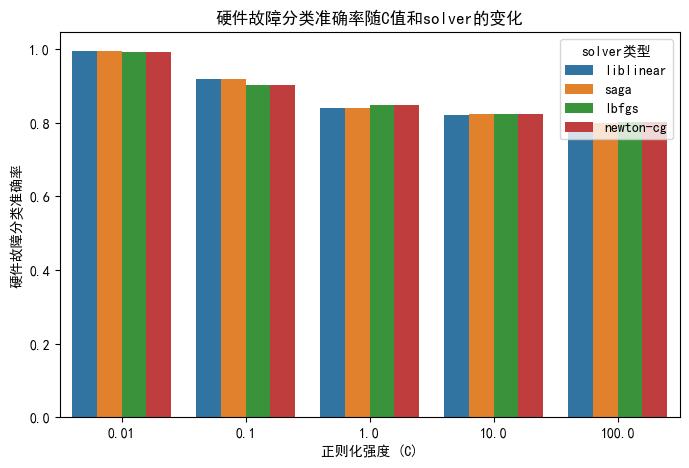

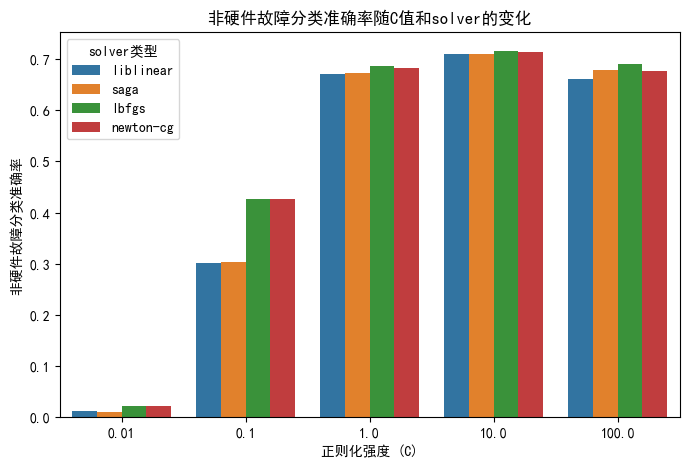

solver分组分析结果已保存到 'solver_analysis_results.xlsx'


In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: 读取调参结果
results_df = pd.read_excel('logistic_regression_tuning_results.xlsx')

# Step 2: 表格分析（按solver分组）
solver_grouped = results_df.groupby('solver')[['整体准确率', '硬件故障分类准确率', '非硬件故障分类准确率']].mean().reset_index()
print("按solver分组的准确率平均值:")
print(solver_grouped)

accuracy_melted = results_df.melt(
    id_vars=['solver'],  # 以solver作为标识变量
    value_vars=['整体准确率', '硬件故障分类准确率', '非硬件故障分类准确率'],  # 要转化的列
    var_name='准确率类型',  # 新列，表示准确率类型
    value_name='准确率值'  # 新列，表示对应的准确率数值
)

# Step 3: 绘制柱状图
plt.figure(figsize=(8, 5))
sns.barplot(data=accuracy_melted, x='solver', y='准确率值', hue='准确率类型', errorbar=None)
plt.title('不同solver的整体、硬件故障与非硬件故障分类准确率')
plt.xlabel('solver类型')
plt.ylabel('准确率')
plt.legend(title='准确率类型')
plt.savefig('solver_accuracy_comparison.png')
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='C', y='整体准确率', hue='solver', errorbar=None)
plt.title('整体准确率随C值和solver的变化')
plt.xlabel('正则化强度 (C)')
plt.ylabel('整体准确率')
plt.legend(title='solver类型')
plt.savefig('all_solver_accuracy_barplot.png')  # 保存图片
plt.show()

# Step 2: 绘制硬件故障分类准确率的柱状图
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='C', y='硬件故障分类准确率', hue='solver', errorbar=None)
plt.title('硬件故障分类准确率随C值和solver的变化')
plt.xlabel('正则化强度 (C)')
plt.ylabel('硬件故障分类准确率')
plt.legend(title='solver类型')
plt.savefig('hardware_accuracy_barplot.png')  # 保存图片
plt.show()

# Step 3: 绘制非硬件故障分类准确率的柱状图
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='C', y='非硬件故障分类准确率', hue='solver', errorbar=None)
plt.title('非硬件故障分类准确率随C值和solver的变化')
plt.xlabel('正则化强度 (C)')
plt.ylabel('非硬件故障分类准确率')
plt.legend(title='solver类型')
plt.savefig('non_hardware_accuracy_barplot.png')  # 保存图片
plt.show()

# Step 5: 保存分组分析结果
solver_grouped.to_excel('solver_analysis_results.xlsx', index=False)
print("solver分组分析结果已保存到 'solver_analysis_results.xlsx'")


In [119]:
param_grid_RF = {
    'n_estimators': [50, 100, 200],   # 决策树数量
    'max_depth': [None, 10, 20],      # 最大树深度
    'min_samples_split': [2, 5, 10]   # 最小分裂样本数
}

results_RF = []
for n_estimators in param_grid_RF['n_estimators']:
    for max_depth in param_grid_RF['max_depth']:
        for min_samples_split in param_grid_RF['min_samples_split']:
            # 初始化模型
            model = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )
            try:
                model.fit(X_train_tfidf, y_train)
                y_pred = model.predict(X_test_tfidf)
                overall_accuracy = accuracy_score(y_test, y_pred)
                hardware_accuracy = accuracy_score(y_test[y_test == '硬件故障'], y_pred[y_test == '硬件故障'])
                non_hardware_accuracy = accuracy_score(y_test[y_test == '非硬件故障'], y_pred[y_test == '非硬件故障'])
                    
                # 记录结果
                results_RF.append({
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    '整体准确率': overall_accuracy,
                    '硬件故障分类准确率': hardware_accuracy,
                    '非硬件故障分类准确率': non_hardware_accuracy
                })
                
                print(f"参数组合: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, 整体准确率={overall_accuracy:.4f}, 硬件故障分类准确率={hardware_accuracy:.4f}, 非硬件故障分类准确率={non_hardware_accuracy:.4f}")
            
            except Exception as e:
                print(f"参数组合失败: penalty={penalty}, C={C}, solver={solver}, 错误={str(e)}")

# Step 7: 保存结果到Excel
results_df = pd.DataFrame(results_RF)
results_df.to_excel('new_random_forest_tuning_results.xlsx', index=False)

sorted_results = results_df.sort_values(by='整体准确率', ascending=False)

print("前5个最佳参数组合:")
print(sorted_results.head())

参数组合: n_estimators=50, max_depth=None, min_samples_split=2, 整体准确率=0.7691, 硬件故障分类准确率=0.7396, 非硬件故障分类准确率=0.8276
参数组合: n_estimators=50, max_depth=None, min_samples_split=5, 整体准确率=0.7655, 硬件故障分类准确率=0.7350, 非硬件故障分类准确率=0.8259
参数组合: n_estimators=50, max_depth=None, min_samples_split=10, 整体准确率=0.7776, 硬件故障分类准确率=0.7477, 非硬件故障分类准确率=0.8366
参数组合: n_estimators=50, max_depth=10, min_samples_split=2, 整体准确率=0.7462, 硬件故障分类准确率=0.6996, 非硬件故障分类准确率=0.8384
参数组合: n_estimators=50, max_depth=10, min_samples_split=5, 整体准确率=0.7438, 硬件故障分类准确率=0.6915, 非硬件故障分类准确率=0.8474
参数组合: n_estimators=50, max_depth=10, min_samples_split=10, 整体准确率=0.7486, 硬件故障分类准确率=0.6978, 非硬件故障分类准确率=0.8492
参数组合: n_estimators=50, max_depth=20, min_samples_split=2, 整体准确率=0.7571, 硬件故障分类准确率=0.7033, 非硬件故障分类准确率=0.8636
参数组合: n_estimators=50, max_depth=20, min_samples_split=5, 整体准确率=0.7565, 硬件故障分类准确率=0.7024, 非硬件故障分类准确率=0.8636
参数组合: n_estimators=50, max_depth=20, min_samples_split=10, 整体准确率=0.7577, 硬件故障分类准确率=0.7051, 非硬件故障分类准确率=0.8618
参数组合: n_estimators=

前5个最佳参数组合:
    n_estimators  max_depth  min_samples_split     整体准确率  硬件故障分类准确率  \
11           100        NaN                 10  0.789030   0.801270   
20           200        NaN                 10  0.788427   0.801270   
2             50        NaN                 10  0.783002   0.795826   
1             50        NaN                  5  0.778782   0.790381   
10           100        NaN                  5  0.778180   0.785844   

    非硬件故障分类准确率  
11    0.764811  
20    0.763016  
2     0.757630  
1     0.755835  
10    0.763016  


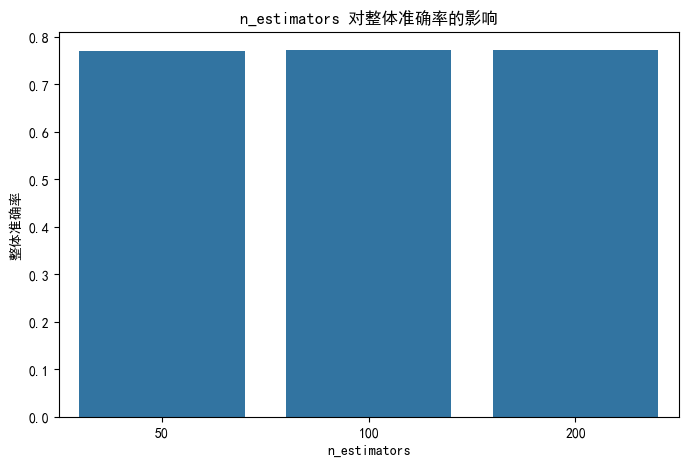

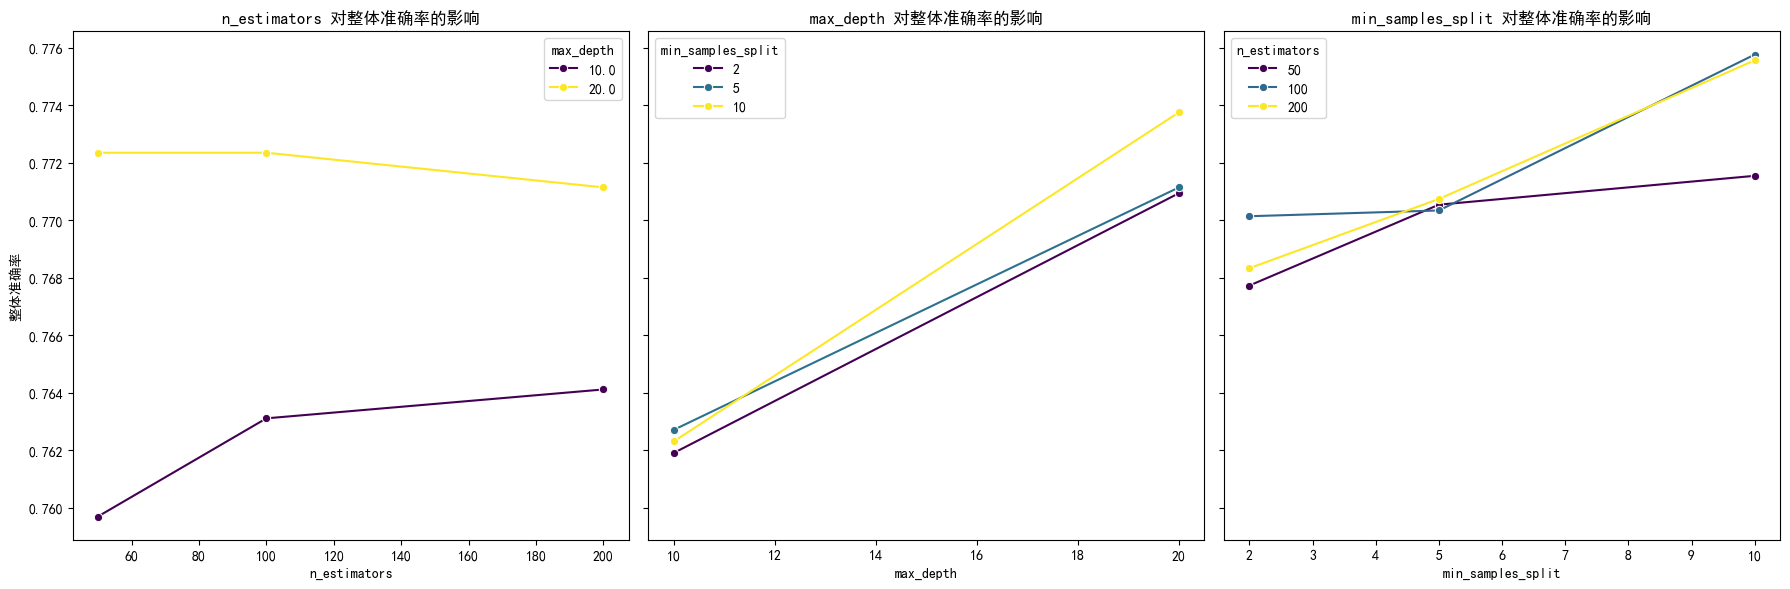

In [107]:
results_df = pd.read_excel('random_forest_tuning_results.xlsx')
sorted_results = results_df.sort_values(by='整体准确率', ascending=False)

print("前5个最佳参数组合:")
print(sorted_results.head())

# Step 3: 绘制柱状图分析分类准确率
plt.figure(figsize=(8, 5))
sns.barplot(data=sorted_results, x='n_estimators', y='整体准确率', errorbar=None)
plt.title('n_estimators 对整体准确率的影响')
plt.xlabel('n_estimators')
plt.ylabel('整体准确率')
plt.savefig('accuracy_analysis_by_n_estimators.png')  # 保存图片
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# n_estimators 对准确率的影响
sns.lineplot(ax=axes[0], x="n_estimators", y="整体准确率", hue="max_depth", data=results_df, marker="o", palette="viridis", errorbar=None)
axes[0].set_title("n_estimators 对整体准确率的影响")
axes[0].set_xlabel("n_estimators")
axes[0].set_ylabel("整体准确率")

# max_depth 对准确率的影响
sns.lineplot(ax=axes[1], x="max_depth", y="整体准确率", hue="min_samples_split", data=results_df, marker="o", palette="viridis", errorbar=None)
axes[1].set_title("max_depth 对整体准确率的影响")
axes[1].set_xlabel("max_depth")

# min_samples_split 对准确率的影响
sns.lineplot(ax=axes[2], x="min_samples_split", y="整体准确率", hue="n_estimators", data=results_df, marker="o", palette="viridis", errorbar=None)
axes[2].set_title("min_samples_split 对整体准确率的影响")
axes[2].set_xlabel("min_samples_split")

plt.tight_layout()
plt.show()


In [120]:
# 定义参数网格
param_grid_SVM = {
    'C': [0.1, 1, 10],              # 惩罚参数
    'kernel': ['linear', 'rbf'],    # 核函数
    'gamma': ['scale', 0.1, 1]      # 核函数系数
}

results_SVM = []
for C in param_grid_SVM['C']:
    for kernel in param_grid_SVM['kernel']:
        for gamma in param_grid_SVM['gamma']:
            # 初始化模型
            model = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
            try:
                # 训练模型
                model.fit(X_train_tfidf, y_train)
                y_pred = model.predict(X_test_tfidf)
                
                # 计算准确率
                overall_accuracy = accuracy_score(y_test, y_pred)
                hardware_accuracy = accuracy_score(y_test[y_test == '硬件故障'], y_pred[y_test == '硬件故障'])
                non_hardware_accuracy = accuracy_score(y_test[y_test == '非硬件故障'], y_pred[y_test == '非硬件故障'])
                
                # 记录结果
                results_SVM.append({
                    'C': C,
                    'kernel': kernel,
                    'gamma': gamma,
                    '整体准确率': overall_accuracy,
                    '硬件故障分类准确率': hardware_accuracy,
                    '非硬件故障分类准确率': non_hardware_accuracy
                })
                
                print(f"参数组合: C={C}, kernel={kernel}, gamma={gamma}, 整体准确率={overall_accuracy:.4f}, 硬件故障分类准确率={hardware_accuracy:.4f}, 非硬件故障分类准确率={non_hardware_accuracy:.4f}")
            
            except Exception as e:
                print(f"参数组合失败: C={C}, kernel={kernel}, gamma={gamma}, 错误={str(e)}")

# 保存结果到Excel
results_df = pd.DataFrame(results_SVM)
results_df.to_excel('new_svm_tuning_results.xlsx', index=False)

sorted_results = results_df.sort_values(by='整体准确率', ascending=False)
print("前5个最佳参数组合:")
print(sorted_results.head())

参数组合: C=0.1, kernel=linear, gamma=scale, 整体准确率=0.7468, 硬件故障分类准确率=0.7005, 非硬件故障分类准确率=0.8384
参数组合: C=0.1, kernel=linear, gamma=0.1, 整体准确率=0.7468, 硬件故障分类准确率=0.7005, 非硬件故障分类准确率=0.8384
参数组合: C=0.1, kernel=linear, gamma=1, 整体准确率=0.7468, 硬件故障分类准确率=0.7005, 非硬件故障分类准确率=0.8384
参数组合: C=0.1, kernel=rbf, gamma=scale, 整体准确率=0.7342, 硬件故障分类准确率=0.6806, 非硬件故障分类准确率=0.8402
参数组合: C=0.1, kernel=rbf, gamma=0.1, 整体准确率=0.6992, 硬件故障分类准确率=0.6234, 非硬件故障分类准确率=0.8492
参数组合: C=0.1, kernel=rbf, gamma=1, 整体准确率=0.7354, 硬件故障分类准确率=0.6824, 非硬件故障分类准确率=0.8402
参数组合: C=1, kernel=linear, gamma=scale, 整体准确率=0.7878, 硬件故障分类准确率=0.7858, 非硬件故障分类准确率=0.7917
参数组合: C=1, kernel=linear, gamma=0.1, 整体准确率=0.7878, 硬件故障分类准确率=0.7858, 非硬件故障分类准确率=0.7917
参数组合: C=1, kernel=linear, gamma=1, 整体准确率=0.7878, 硬件故障分类准确率=0.7858, 非硬件故障分类准确率=0.7917
参数组合: C=1, kernel=rbf, gamma=scale, 整体准确率=0.7842, 硬件故障分类准确率=0.7786, 非硬件故障分类准确率=0.7953
参数组合: C=1, kernel=rbf, gamma=0.1, 整体准确率=0.7607, 硬件故障分类准确率=0.7187, 非硬件故障分类准确率=0.8438
参数组合: C=1, kernel=rbf, gamma=1, 整体准确率=0.7860

In [121]:
# results_df = pd.read_excel('svm_tuning_results.xlsx')
sorted_results = results_df.sort_values(by='整体准确率', ascending=False)

print("前5个最佳参数组合:")
print(sorted_results.head())

前5个最佳参数组合:
       C  kernel  gamma     整体准确率  硬件故障分类准确率  非硬件故障分类准确率
8    1.0  linear      1  0.787824   0.785844    0.791741
7    1.0  linear    0.1  0.787824   0.785844    0.791741
6    1.0  linear  scale  0.787824   0.785844    0.791741
11   1.0     rbf      1  0.786016   0.780399    0.797127
16  10.0     rbf    0.1  0.786016   0.808530    0.741472


In [122]:
# 朴素贝叶斯
from sklearn.naive_bayes import MultinomialNB

param_grid_NB = {
    'alpha': [0.1, 0.5, 1.0, 2.0],  # 平滑参数
    'fit_prior': [True, False]      # 是否学习类别的先验概率
}

results_NB = []
for alpha in param_grid_NB['alpha']:
    for fit_prior in param_grid_NB['fit_prior']:
        # 初始化模型
        model = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
        try:
            # 训练模型
            model.fit(X_train_tfidf, y_train)
            y_pred = model.predict(X_test_tfidf)
            
            # 计算准确率
            overall_accuracy = accuracy_score(y_test, y_pred)
            hardware_accuracy = accuracy_score(y_test[y_test == '硬件故障'], y_pred[y_test == '硬件故障'])
            non_hardware_accuracy = accuracy_score(y_test[y_test == '非硬件故障'], y_pred[y_test == '非硬件故障'])
            
            # 记录结果
            results_NB.append({
                'alpha': alpha,
                'fit_prior': fit_prior,
                '整体准确率': overall_accuracy,
                '硬件故障分类准确率': hardware_accuracy,
                '非硬件故障分类准确率': non_hardware_accuracy
            })
            
            print(f"参数组合: alpha={alpha}, fit_prior={fit_prior}, 整体准确率={overall_accuracy:.4f}, 硬件故障分类准确率={hardware_accuracy:.4f}, 非硬件故障分类准确率={non_hardware_accuracy:.4f}")
        
        except Exception as e:
            print(f"参数组合失败: alpha={alpha}, fit_prior={fit_prior}, 错误={str(e)}")

# 保存结果到Excel
results_df = pd.DataFrame(results_NB)
results_df.to_excel('new_naive_bayes_tuning_results.xlsx', index=False)

sorted_results = results_df.sort_values(by='整体准确率', ascending=False)

print("前5个最佳参数组合:")
print(sorted_results.head())

参数组合: alpha=0.1, fit_prior=True, 整体准确率=0.7336, 硬件故障分类准确率=0.6760, 非硬件故障分类准确率=0.8474
参数组合: alpha=0.1, fit_prior=False, 整体准确率=0.7336, 硬件故障分类准确率=0.6760, 非硬件故障分类准确率=0.8474
参数组合: alpha=0.5, fit_prior=True, 整体准确率=0.7450, 硬件故障分类准确率=0.6996, 非硬件故障分类准确率=0.8348
参数组合: alpha=0.5, fit_prior=False, 整体准确率=0.7450, 硬件故障分类准确率=0.6996, 非硬件故障分类准确率=0.8348
参数组合: alpha=1.0, fit_prior=True, 整体准确率=0.7480, 硬件故障分类准确率=0.7051, 非硬件故障分类准确率=0.8330
参数组合: alpha=1.0, fit_prior=False, 整体准确率=0.7480, 硬件故障分类准确率=0.7051, 非硬件故障分类准确率=0.8330
参数组合: alpha=2.0, fit_prior=True, 整体准确率=0.7541, 硬件故障分类准确率=0.7260, 非硬件故障分类准确率=0.8097
参数组合: alpha=2.0, fit_prior=False, 整体准确率=0.7541, 硬件故障分类准确率=0.7260, 非硬件故障分类准确率=0.8097
前5个最佳参数组合:
   alpha  fit_prior     整体准确率  硬件故障分类准确率  非硬件故障分类准确率
6    2.0       True  0.754069   0.725953    0.809695
7    2.0      False  0.754069   0.725953    0.809695
4    1.0       True  0.748041   0.705082    0.833034
5    1.0      False  0.748041   0.705082    0.833034
2    0.5       True  0.745027   0.699637    0.834829


In [123]:
# 梯度提升树
from sklearn.ensemble import GradientBoostingClassifier

param_grid_GB = {
    'n_estimators': [50, 100, 200],  # 弱学习器数量
    'learning_rate': [0.01, 0.1, 0.2],  # 学习率
    'max_depth': [3, 5, 10]  # 最大树深度
}

results_GB = []

# 遍历参数组合
for n_estimators in param_grid_GB['n_estimators']:
    for learning_rate in param_grid_GB['learning_rate']:
        for max_depth in param_grid_GB['max_depth']:
            # 初始化梯度提升树模型
            model = GradientBoostingClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                random_state=42
            )
            
            try:
                # 模型训练
                model.fit(X_train_tfidf, y_train)
                
                # 模型预测
                y_pred = model.predict(X_test_tfidf)
                
                # 计算准确率
                overall_accuracy = accuracy_score(y_test, y_pred)
                hardware_accuracy = accuracy_score(y_test[y_test == '硬件故障'], y_pred[y_test == '硬件故障'])
                non_hardware_accuracy = accuracy_score(y_test[y_test == '非硬件故障'], y_pred[y_test == '非硬件故障'])
                
                # 记录结果
                results_GB.append({
                    'n_estimators': n_estimators,
                    'learning_rate': learning_rate,
                    'max_depth': max_depth,
                    '整体准确率': overall_accuracy,
                    '硬件故障分类准确率': hardware_accuracy,
                    '非硬件故障分类准确率': non_hardware_accuracy
                })
                
                print(f"参数组合: n_estimators={n_estimators}, learning_rate={learning_rate}, max_depth={max_depth}, 整体准确率={overall_accuracy:.4f}, 硬件故障分类准确率={hardware_accuracy:.4f}, 非硬件故障分类准确率={non_hardware_accuracy:.4f}")
            except Exception as e:
                print(f"参数组合失败: n_estimators={n_estimators}, learning_rate={learning_rate}, max_depth={max_depth}, 错误={str(e)}")

# 保存结果到Excel
results_df = pd.DataFrame(results_GB)
results_df.to_excel('new_gradient_boosting_tuning_results.xlsx', index=False)
sorted_results = results_df.sort_values(by='整体准确率', ascending=False)

print("前5个最佳参数组合:")
print(sorted_results.head())

参数组合: n_estimators=50, learning_rate=0.01, max_depth=3, 整体准确率=0.7366, 硬件故障分类准确率=0.7069, 非硬件故障分类准确率=0.7953
参数组合: n_estimators=50, learning_rate=0.01, max_depth=5, 整体准确率=0.7450, 硬件故障分类准确率=0.7287, 非硬件故障分类准确率=0.7774
参数组合: n_estimators=50, learning_rate=0.01, max_depth=10, 整体准确率=0.7631, 硬件故障分类准确率=0.7359, 非硬件故障分类准确率=0.8169
参数组合: n_estimators=50, learning_rate=0.1, max_depth=3, 整体准确率=0.7830, 硬件故障分类准确率=0.7650, 非硬件故障分类准确率=0.8187
参数组合: n_estimators=50, learning_rate=0.1, max_depth=5, 整体准确率=0.7800, 硬件故障分类准确率=0.7695, 非硬件故障分类准确率=0.8007
参数组合: n_estimators=50, learning_rate=0.1, max_depth=10, 整体准确率=0.7752, 硬件故障分类准确率=0.7686, 非硬件故障分类准确率=0.7882
参数组合: n_estimators=50, learning_rate=0.2, max_depth=3, 整体准确率=0.7709, 硬件故障分类准确率=0.7623, 非硬件故障分类准确率=0.7882
参数组合: n_estimators=50, learning_rate=0.2, max_depth=5, 整体准确率=0.7824, 硬件故障分类准确率=0.7840, 非硬件故障分类准确率=0.7792
参数组合: n_estimators=50, learning_rate=0.2, max_depth=10, 整体准确率=0.7752, 硬件故障分类准确率=0.7731, 非硬件故障分类准确率=0.7792
参数组合: n_estimators=100, learning_rate=0.01, max_d

In [9]:
from xgboost import XGBClassifier

param_grid_XGB = {
    'n_estimators': [50, 100, 200],  # 弱学习器的数量
    'max_depth': [3, 6, 10],         # 树的最大深度
    'learning_rate': [0.01, 0.1, 0.2], # 学习率
    'subsample': [0.6, 0.8, 1.0]     # 采样比例
}

results_XGB = []
for n_estimators in param_grid_XGB['n_estimators']:
    for max_depth in param_grid_XGB['max_depth']:
        for learning_rate in param_grid_XGB['learning_rate']:
            for subsample in param_grid_XGB['subsample']:
                # 初始化模型
                model = XGBClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    learning_rate=learning_rate,
                    subsample=subsample,
                    use_label_encoder=False,  # 忽略警告
                    random_state=42
                )
                try:
                    # 训练模型
                    model.fit(X_train_tfidf, y_train)
                    y_pred = model.predict(X_test_tfidf)

                    # 计算准确率
                    overall_accuracy = accuracy_score(y_test, y_pred)
                    hardware_accuracy = accuracy_score(y_test[y_test == '硬件故障'], y_pred[y_test == '硬件故障'])
                    non_hardware_accuracy = accuracy_score(y_test[y_test == '非硬件故障'], y_pred[y_test == '非硬件故障'])

                    # 记录结果
                    results_XGB.append({
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'learning_rate': learning_rate,
                        'subsample': subsample,
                        '整体准确率': overall_accuracy,
                        '硬件故障分类准确率': hardware_accuracy,
                        '非硬件故障分类准确率': non_hardware_accuracy
                    })

                    print(f"参数组合: n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate}, subsample={subsample}, 整体准确率={overall_accuracy:.4f}, 硬件故障分类准确率={hardware_accuracy:.4f}, 非硬件故障分类准确率={non_hardware_accuracy:.4f}")
                
                except Exception as e:
                    print(f"参数组合失败: n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate}, subsample={subsample}, 错误={str(e)}")

# 保存结果到Excel
results_df = pd.DataFrame(results_XGB)
results_df.to_excel('xgboost_tuning_results.xlsx', index=False)

sorted_results = results_df.sort_values(by='整体准确率', ascending=False)

print("前5个最佳参数组合:")
print(sorted_results.head())

参数组合失败: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.6, 错误=Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['硬件故障' '非硬件故障']
参数组合失败: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.8, 错误=Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['硬件故障' '非硬件故障']
参数组合失败: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=1.0, 错误=Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['硬件故障' '非硬件故障']
参数组合失败: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.6, 错误=Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['硬件故障' '非硬件故障']
参数组合失败: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.8, 错误=Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['硬件故障' '非硬件故障']
参数组合失败: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=1.0, 错误=Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['硬件故障' '非硬件故障']
参

KeyError: '整体准确率'

In [97]:
!pip install autogluon

Looking in indexes: https://mirrors.tools.huawei.com/pypi/simple


In [ ]:
from autogluon.tabular import TabularPredictor

In [124]:
from autogluon.tabular import TabularPredictor
import pandas as pd

# 读取数据
# data = pd.read_excel('D:\\Files\\Data\\最新\\事件单分析\\场景\\11-12全部.xlsx')
data = pd.read_excel('D:\\Files\\Data\\最新\\事件单分析\\场景\\2024年11-12月标题描述.xlsx')

data = data.dropna(subset=['事件单号', '事件标题', '事件描述', '一层事件类别'])  # 清理缺失数据

# 定义标签
target_categories = ['服务器硬件问题', '产品问题', '网络设备硬件问题', '未定位根因']
data['分类类别'] = data['一层事件类别'].apply(lambda x: '硬件故障' if x in target_categories else '非硬件故障')
data['综合描述'] = data['事件标题'] + " " + data['事件描述']

# 数据集切分
X = data['综合描述']  
y = data['分类类别'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 文本特征提取（TF-IDF）
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [125]:
# 将提取的特征转换为 Pandas DataFrame（供 AutoGluon 使用）
X_train_df = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
X_train_df['分类类别'] = y_train.values  # 添加目标列
X_test_df = pd.DataFrame(X_test_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
X_test_df['分类类别'] = y_test.values  # 添加目标列

# 使用 AutoGluon 训练模型
predictor = TabularPredictor(label='分类类别', eval_metric='accuracy').fit(X_train_df)

# 对测试集进行预测
X_test_features_only = X_test_df.drop(columns=['分类类别'])  # 去掉目标列
X_test_df['预测类别'] = predictor.predict(X_test_features_only)

# 模型性能评估
performance = predictor.evaluate(X_test_df)
print("模型表现:", performance)

# 导出预测结果
X_test_df.to_excel('事件单分类预测结果_TFIDF.xlsx', index=False)

# 查看模型排名和详细信息
print(predictor.leaderboard())

No path specified. Models will be saved in: "AutogluonModels\ag-20250327_083928"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.3
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
Memory Avail:       9.13 GB / 31.80 GB (28.7%)
Disk Space Avail:   683.79 GB / 733.24 GB (93.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         

模型表现: {'accuracy': 0.7890295358649789, 'balanced_accuracy': np.float64(0.7888122460549938), 'mcc': np.float64(0.55580731997257), 'roc_auc': np.float64(0.854530036786388), 'f1': 0.7149837133550488, 'precision': 0.65424739195231, 'recall': 0.7881508078994613}
                 model  score_val eval_metric  pred_time_val   fit_time  \
0  WeightedEnsemble_L2   0.832831    accuracy       0.794580  59.838547   
1       ExtraTreesEntr   0.825301    accuracy       0.098415  13.848935   
2       ExtraTreesGini   0.817771    accuracy       0.099185  13.657893   
3     RandomForestEntr   0.811747    accuracy       0.098172  10.669450   
4              XGBoost   0.805723    accuracy       0.102001  26.069254   
5     RandomForestGini   0.804217    accuracy       0.102194  10.818490   
6      NeuralNetFastAI   0.802711    accuracy       0.179029  32.430126   
7       KNeighborsDist   0.736446    accuracy       0.417965   2.832037   
8       KNeighborsUnif   0.725904    accuracy       0.606579   5.12

In [18]:
models = {
    "逻辑回归": LogisticRegression(random_state=42),
    "支持向量机": SVC(kernel='linear', probability=True, random_state=42),
    "随机森林": RandomForestClassifier(random_state=42, n_estimators=100),
}

In [23]:
for model_name, model in models.items():
    print(f"训练模型: {model_name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    # 统计分类准确率
    hardware_accuracy = accuracy_score(y_test[y_test == '硬件故障'], y_pred[y_test == '硬件故障'])
    non_hardware_accuracy = accuracy_score(y_test[y_test == '非硬件故障'], y_pred[y_test == '非硬件故障'])
    hardware_misclassification_rate = sum((y_test == '硬件故障') & (y_pred == '非硬件故障')) / sum(y_test == '硬件故障')
    non_hardware_misclassification_rate = sum((y_test == '非硬件故障') & (y_pred == '硬件故障')) / sum(y_test == '非硬件故障')
    
    print(f"硬件故障分类准确率: {hardware_accuracy:.2f}")
    print(f"非硬件故障分类准确率: {non_hardware_accuracy:.2f}")
    print(f"硬件故障误分类为非硬件故障率: {hardware_misclassification_rate:.2f}")
    print(f"非硬件故障误分类为硬件故障率: {non_hardware_misclassification_rate:.2f}")

训练模型: 逻辑回归...
硬件故障分类准确率: 0.85
非硬件故障分类准确率: 0.69
硬件故障误分类为非硬件故障率: 0.15
非硬件故障误分类为硬件故障率: 0.31
训练模型: 支持向量机...
硬件故障分类准确率: 0.82
非硬件故障分类准确率: 0.74
硬件故障误分类为非硬件故障率: 0.18
非硬件故障误分类为硬件故障率: 0.26
训练模型: 随机森林...
硬件故障分类准确率: 0.79
非硬件故障分类准确率: 0.75
硬件故障误分类为非硬件故障率: 0.21
非硬件故障误分类为硬件故障率: 0.25


In [8]:
test_results = pd.DataFrame({
    '事件单号': data.loc[X_test.index, '事件单号'],
    '事件标题': data.loc[X_test.index, '事件标题'],
    '事件描述': data.loc[X_test.index, '事件描述'],
    '一层事件类别': data.loc[X_test.index, '一层事件类别'],
    '分类类别': y_pred  # 预测的分类类别
})

In [10]:
test_results.to_excel('test_results.xlsx', index=False)

In [11]:
# 统计分类准确率
hardware_accuracy = accuracy_score(y_test[y_test == '硬件故障'], y_pred[y_test == '硬件故障'])
non_hardware_accuracy = accuracy_score(y_test[y_test == '非硬件故障'], y_pred[y_test == '非硬件故障'])
hardware_misclassification_rate = sum((y_test == '硬件故障') & (y_pred == '非硬件故障')) / sum(y_test == '硬件故障')
non_hardware_misclassification_rate = sum((y_test == '非硬件故障') & (y_pred == '硬件故障')) / sum(y_test == '非硬件故障')

print(f"硬件故障分类准确率: {hardware_accuracy:.2f}")
print(f"非硬件故障分类准确率: {non_hardware_accuracy:.2f}")
print(f"硬件故障误分类为非硬件故障率: {hardware_misclassification_rate:.2f}")
print(f"非硬件故障误分类为硬件故障率: {non_hardware_misclassification_rate:.2f}")

硬件故障分类准确率: 0.76
非硬件故障分类准确率: 0.81
硬件故障误分类为非硬件故障率: 0.24
非硬件故障误分类为硬件故障率: 0.19
